<a href="https://colab.research.google.com/github/AnaisGuillem/historicplacesmerced/blob/master/PanopticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

## Installing Dependencies

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
#we also need opencv but is already installed in google colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 1.7MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Install Detectron2

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.9MB 602kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=12d5231929ec7c5cd19d3162c82820bb39e00cb64b8290e55d11ee7c059d3018
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore


## Import Libraries and utilities

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import matplotlib.pyplot as plt

# Preprocessing

## Transform data to coco format

In [ ]:
pip install labelme2coco

In [ ]:
# import package
import labelme2coco

# set directory that contains labelme annotations and image files
labelme_folder = "/content/train_house"

# set path for coco json to be saved
save_json_path = "/content/train_coco_house.json"

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, save_json_path)

# Panoptic Segmentation

## Registering new data-set

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "training_coco.json", "/content/train_house")
register_coco_instances("my_dataset_test", {}, "validation_coco.json", "/content/test")

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Trying a new registraition method


In [8]:
!ls "Stairs Segmentation"

labelme2coco.py  test  test.json  train  train.json


In [9]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"stairs_{d}", {}, f"Stairs Segmentation/{d}.json", f"Stairs Segmentation/{d}")

[07/19 01:25:20 d2.data.datasets.coco]: Loaded 33 images in COCO format from Stairs Segmentation/train.json


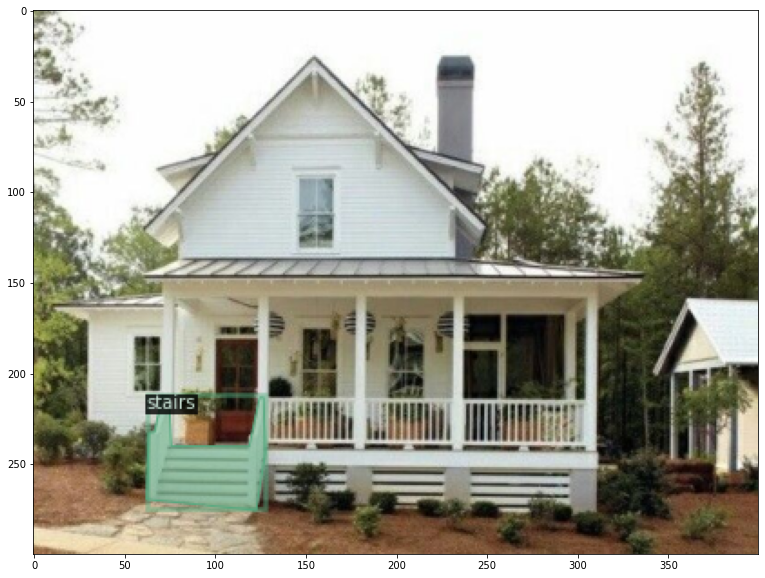

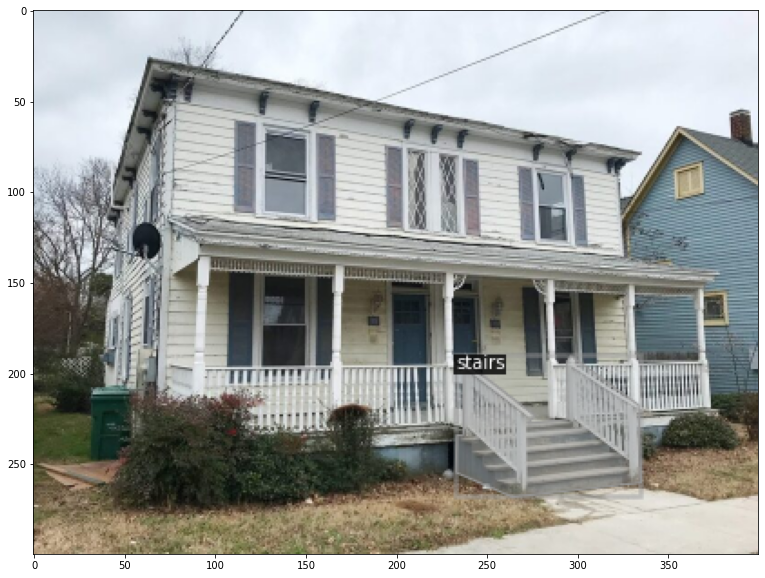

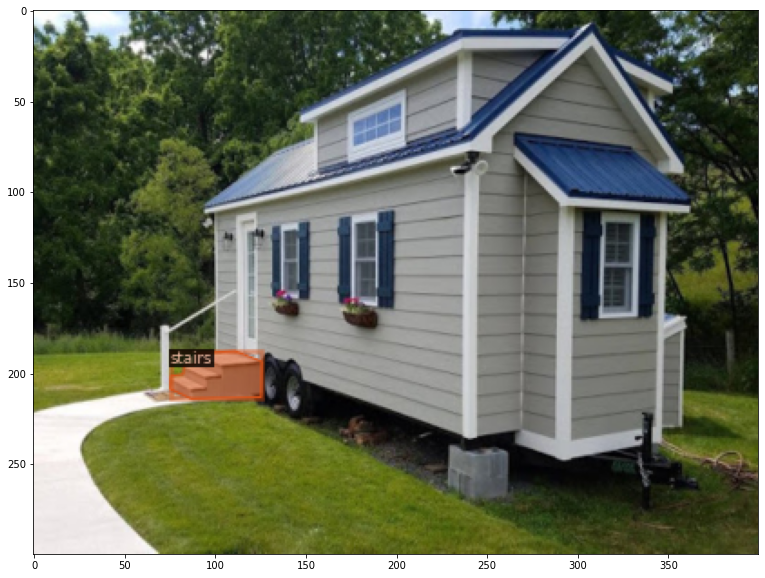

In [18]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("stairs_train")
stairs_metadata = MetadataCatalog.get("stairs_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=stairs_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [19]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("stairs_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/19 01:28:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:07, 22.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[07/19 01:29:11 d2.engine.train_loop]: Starting training from iteration 0
[07/19 01:29:17 d2.utils.events]:  eta: 0:04:38  iter: 19  total_loss: 1.568  loss_cls: 0.742  loss_box_reg: 0.060  loss_mask: 0.690  loss_rpn_cls: 0.037  loss_rpn_loc: 0.009  time: 0.2822  data_time: 0.0173  lr: 0.000005  max_mem: 2337M
[07/19 01:29:23 d2.utils.events]:  eta: 0:04:34  iter: 39  total_loss: 1.435  loss_cls: 0.647  loss_box_reg: 0.074  loss_mask: 0.684  loss_rpn_cls: 0.022  loss_rpn_loc: 0.006  time: 0.2842  data_time: 0.0060  lr: 0.000010  max_mem: 2338M
[07/19 01:29:28 d2.utils.events]:  eta: 0:04:32  iter: 59  total_loss: 1.289  loss_cls: 0.483  loss_box_reg: 0.079  loss_mask: 0.676  loss_rpn_cls: 0.035  loss_rpn_loc: 0.008  time: 0.2864  data_time: 0.0047  lr: 0.000015  max_mem: 2338M
[07/19 01:29:34 d2.utils.events]:  eta: 0:04:26  iter: 79  total_loss: 1.121  loss_cls: 0.348  loss_box_reg: 0.060  loss_mask: 0.656  loss_rpn_cls: 0.043  loss_rpn_loc: 0.006  time: 0.2866  data_time: 0.0046  lr:

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("stairs_test", )
predictor = DefaultPredictor(cfg)

[07/19 01:38:52 d2.data.datasets.coco]: Loaded 9 images in COCO format from Stairs Segmentation/test.json


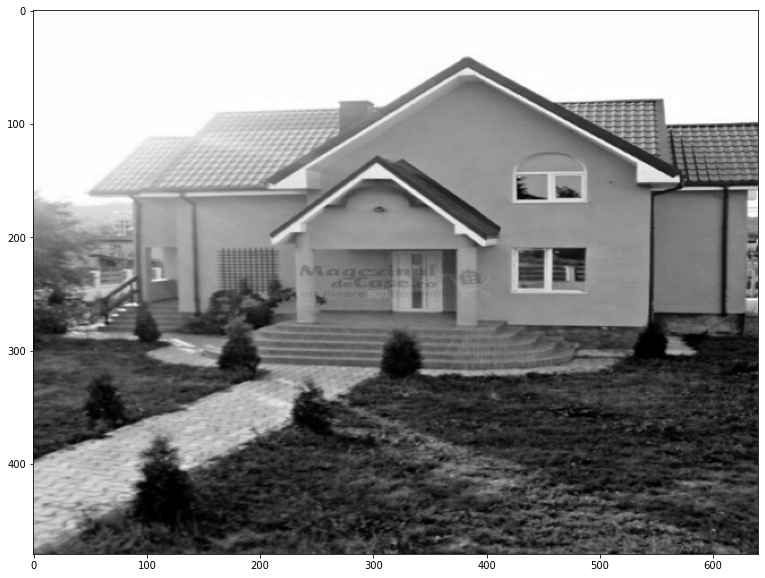

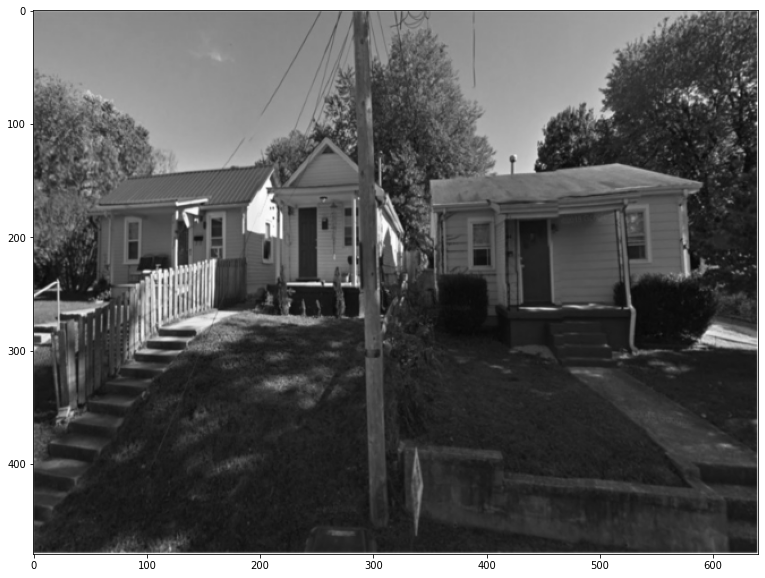

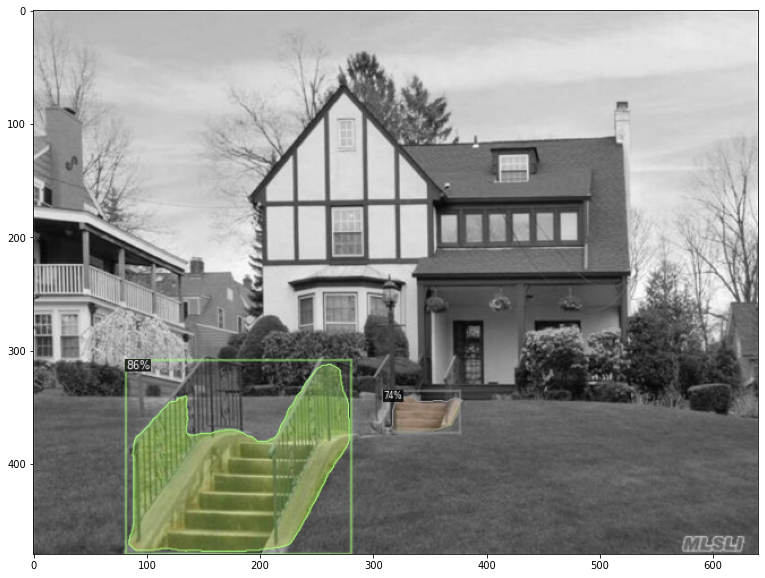

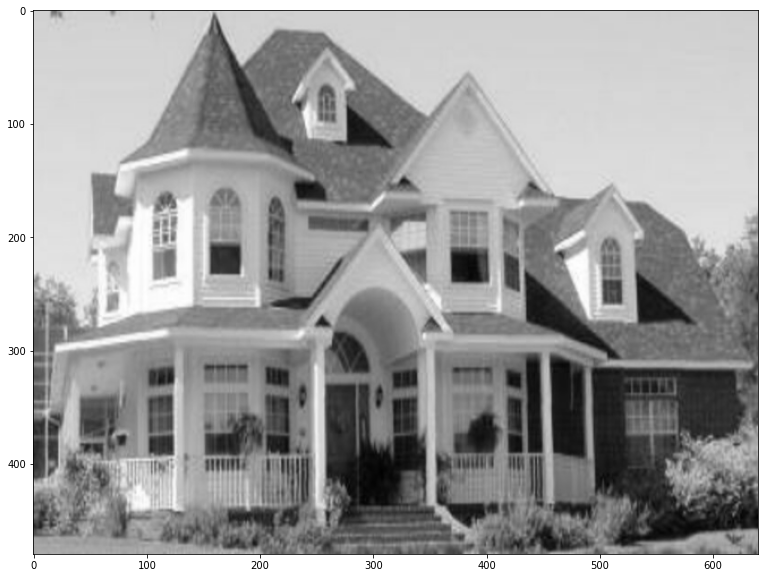

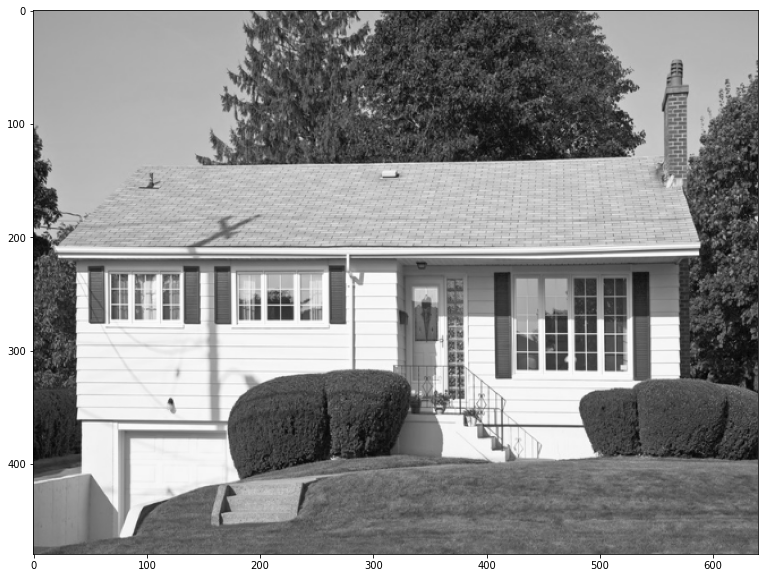

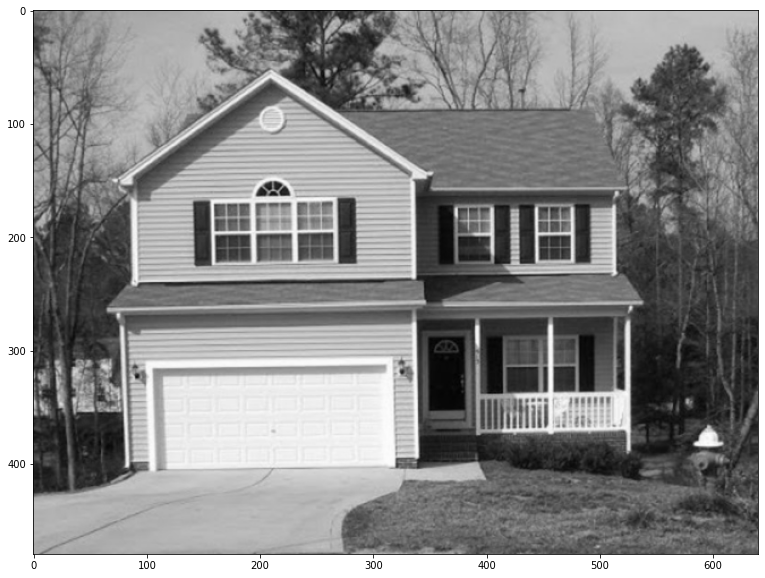

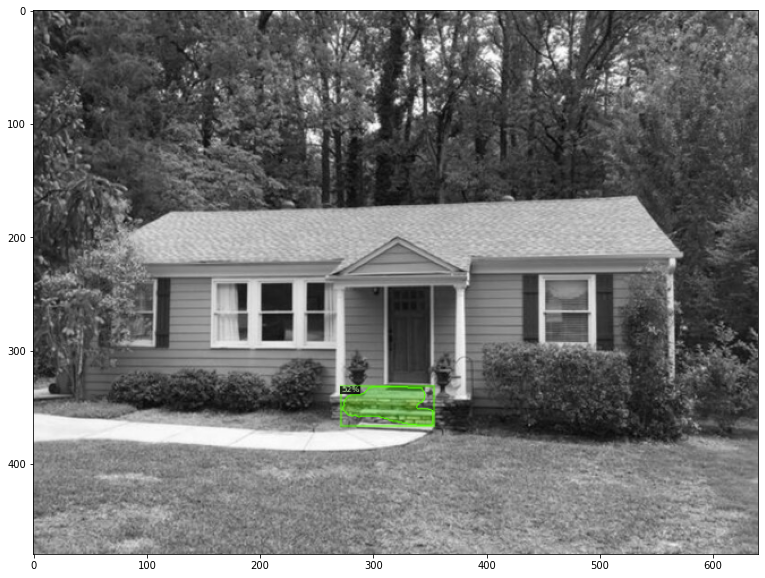

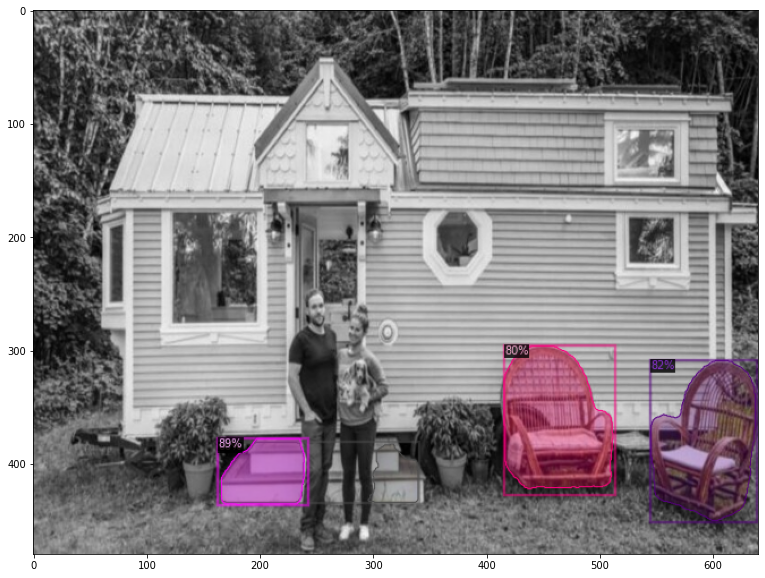

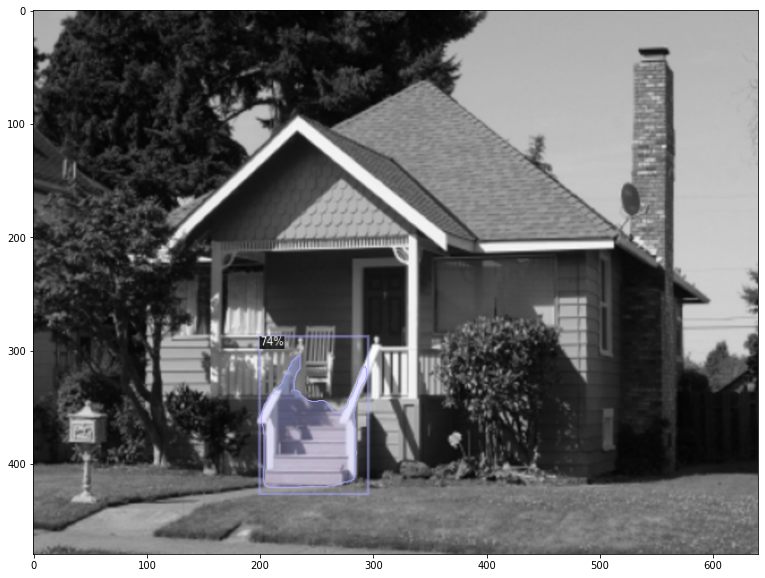

In [23]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("stairs_test")
for d in random.sample(dataset_dicts, 9):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=stairs_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [30]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("stairs_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "stairs_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[07/19 01:43:18 d2.data.datasets.coco]: Loaded 9 images in COCO format from Stairs Segmentation/test.json
[07/19 01:43:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   stairs   | 19           |
|            |              |
[07/19 01:43:18 d2.data.common]: Serializing 9 elements to byte tensors and concatenating them all ...
[07/19 01:43:18 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/19 01:43:18 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/19 01:43:18 d2.evaluation.evaluator]: Start inference on 9 images
[07/19 01:43:19 d2.evaluation.evaluator]: Total inference time: 0:00:00.393733 (0.098433 s / img per device, on 1 devices)
[07/19 01:43:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.066151 s / img per device, on 1 devices)
[07/19 01:43:19 d2.evaluation.coco_eva

## Loading Images

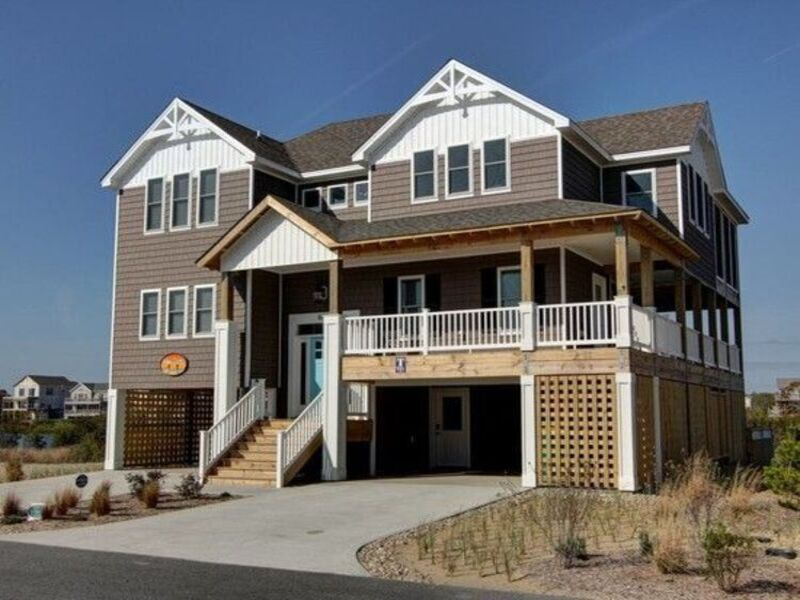

In [25]:
path = '/content/1.jpg'
img = cv2.imread(path) 
cv2_imshow(img)

## Segmentation

model_final_cafdb1.pkl: 261MB [00:14, 17.6MB/s]                           


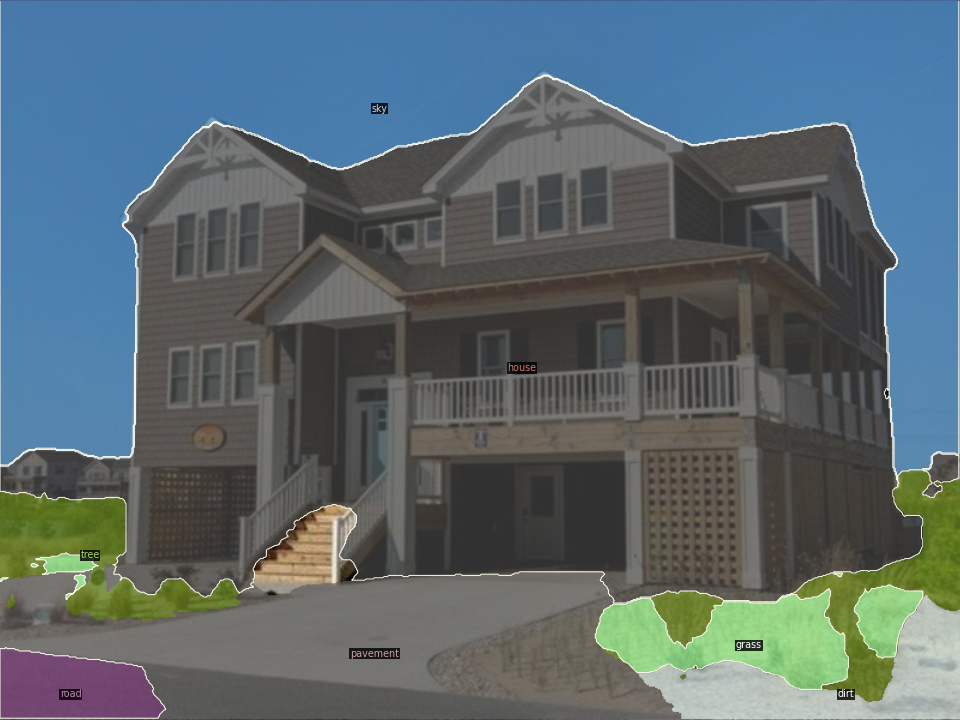

In [26]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])
outputs = predictor(img)

## Get image from the mask


**ISSUE: pred_masks is not defined in panoptic_seg **

In [ ]:
masks = outputs["panoptic_seg"].pred_masks.cpu().numpy()
print(masks)

# numcolors = 256
# image = Image.open(image_str)
# results = iamge.converter('P', palette=Image.ADAPTIVE, colors=numcolors)
# results.putalpha(0)
# colors_in_image = result.converter('RGB').getcolors()
# print(colors_in_image)
# list_colors_in_image = []

# for count, color in colors_in_image:
#   rgb = color 
#   try:
#     name = webcolors.rgb_to_name(rgb)
#     except ValueError:
#       name = closest_color(rbg)
#     list_colors_in_image.append((count, name))
#   return list_colors_in_image

AttributeError: ignored

In [ ]:
def image_mask(mask, box, img):
  mask_

In [ ]:
print(outputs["instances"].pred_masks.cpu())

tensor([], size=(0, 441, 665), dtype=torch.uint8)


# Instance Segmentation

## Transform data to coco format

In [ ]:
#install
pip install labelme2coco

In [ ]:
# import package
import labelme2coco

# set directory that contains labelme annotations and image files
labelme_folder = "/content/validation"

# set path for coco json to be saved
save_json_path = "/content/validation_coco.json"

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, save_json_path)

## Registering new data-set

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "training_coco.json", "/content/training_coco.json")
register_coco_instances("my_dataset_val", {}, "validation_coco.json", "/content/validation_coco.json")

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Load images

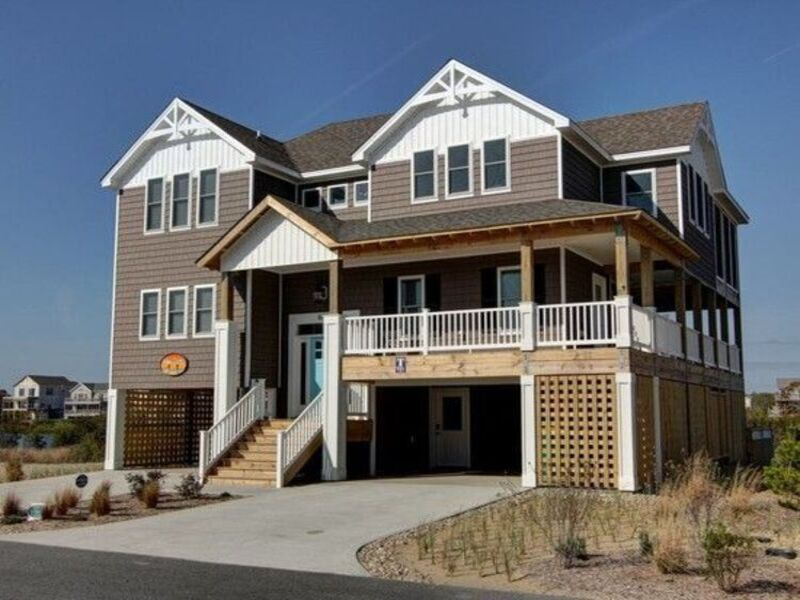

In [27]:
path = '/content/1.jpg'
img = cv2.imread(path) 
cv2_imshow(img)

## Segmentation

In [ ]:
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
# v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(out.get_image()[:, :, ::-1])
# outputs = predictor(img)

In [28]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

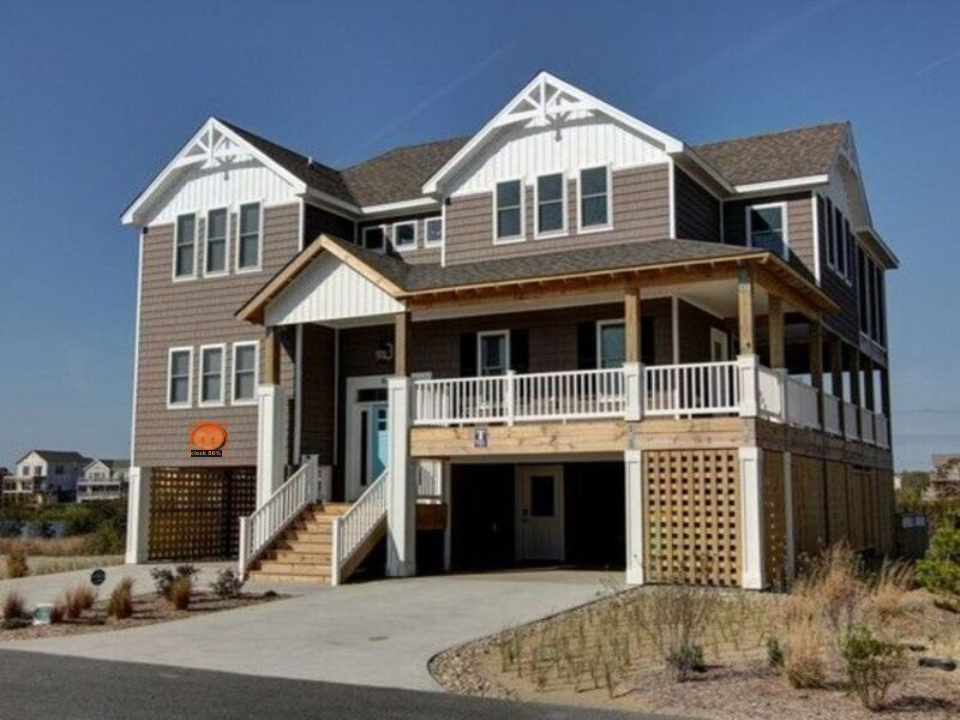

In [29]:
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Data extraction 

### Finding the category_id of each mask

In [ ]:
print("Segment information: ", segments_info)
print("Categories ids: ")
for data in segments_info:
  print("               ", data.get("category_id"))
  # print(segments_info[i]["category_id"]) is an alternative 


Segment information:  [{'id': 1, 'isthing': True, 'score': 0.9728285074234009, 'category_id': 2, 'instance_id': 0, 'area': 337.0}, {'id': 2, 'isthing': True, 'score': 0.874255359172821, 'category_id': 58, 'instance_id': 1, 'area': 13228.0}, {'id': 3, 'isthing': True, 'score': 0.8603115677833557, 'category_id': 2, 'instance_id': 2, 'area': 129.0}, {'id': 4, 'isthing': False, 'category_id': 12, 'area': 139541.0}, {'id': 5, 'isthing': False, 'category_id': 37, 'area': 25387.0}, {'id': 6, 'isthing': False, 'category_id': 40, 'area': 45664.0}, {'id': 7, 'isthing': False, 'category_id': 44, 'area': 7052.0}]
Categories ids: 
                2
                58
                2
                12
                37
                40
                44


## Finding the "stuff" or "thing" corresponding to the category_id

In [ ]:
for data in segments_info:
  print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes[data.get("category_id")])

blanket


IndexError: ignored

## Finding instances and id 

In [ ]:
print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:

for data in outputs["instances"].pred_classes:
    num = data.item()
    print(num, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[num])
    

2 car
58 potted plant
2 car
2 car
58 potted plant
13 bench
